<a href="https://colab.research.google.com/github/manovay/msml/blob/main/unit07_optim/lab_nlls_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab:  Nonlinear Least Squares for Modeling Materials

In this lab, we will explore gradient descent on nonlinear least squares.  Suppose we wish to fit a model of the form,

     yhat = f(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  In nonlinear least squares, we find `w` by minimizing a least-squares function

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  In general, this optimization has no closed-form expression.  So gradient descent is widely used.  

In this lab, we will implement gradient descent on nonlinear least squares in physical modeling of materials.  Specifically, e we will estimate parameters for expansion of copper as a function of temperature.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for trying nonlinear regression problem.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.  Note that if you directly use the `pd.read_csv(url, ...)` command you will get an HTTP 403 error.  The code below makes it appear as if the request is coming from a browser.

In [2]:
url = 'https://www.itl.nist.gov/div898/handbook/datasets/HAHN1.DAT'


import pandas as pd
import requests
from io import StringIO

# Simulate a browser request
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

# Raise an error if the request failed
response.raise_for_status()

# Read the content into pandas
data = StringIO(response.text)
df = pd.read_csv(data, sep='\s+', header=None, skiprows=25)
df.columns = ["x0", "y0"]

df.head()

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2360235624.py:17: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(data, sep='\s+', header=None, skiprows=25)


,x0,y0
0,24.41,0.591
1,34.82,1.547
2,44.09,2.902
3,45.07,2.894
4,54.98,4.703


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`.

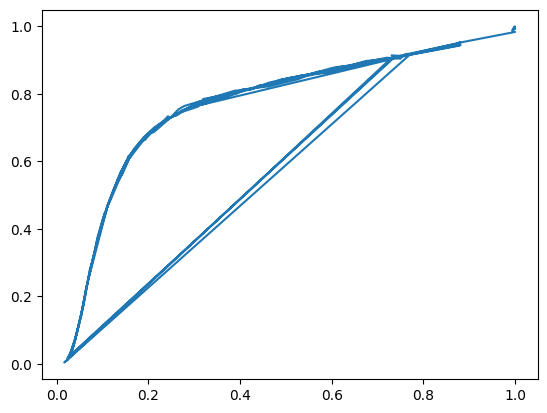

In [3]:
# TODO
x0 = df['x0'].values
y0 = df['y0'].values
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y)

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

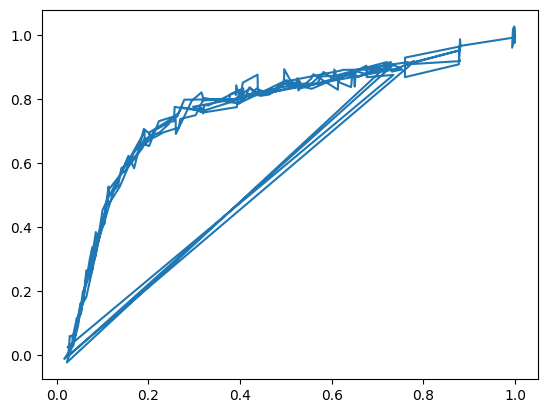

In [5]:
# TODO
yn = y + np.random.normal(0,0.02,len(y))
plt.plot(x,yn)


Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [10]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [12]:
def predict(w,x):

    # Get the length
    d = (len(w)-1)//2

    # TODO.  Extract a and b from
    a =  w[:d+1]
    b =  w[d+1:]


    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    # yhat = ...
    yhat = np.polyval(np.flip(a),x) + np.polyval(np.flip(b),x)
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ]

In [13]:
d = 3

# TODO.  Create the transformed feature matrix
Z = np.zeros((len(xtr),2*d))
for i in range(d):
    Z[:,i] = xtr**(i+1)
    Z[:,i+d] = ytr * (xtr**(i+1))

# TODO.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(Z, ytr)


# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
winit = np.concatenate(([regr.intercept_], regr.coef_[:d], -regr.coef_[d:]))

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

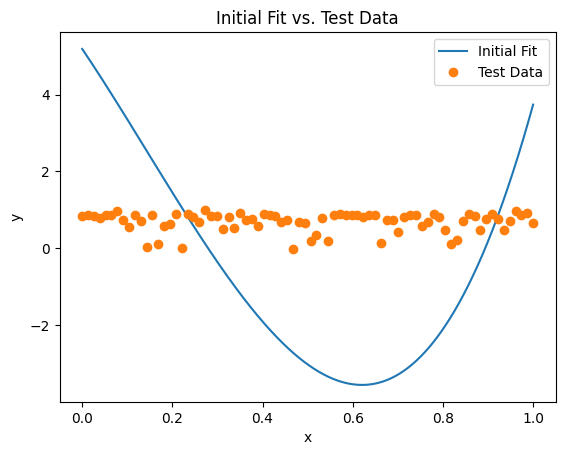

In [17]:
# TODO
xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat, label='Initial Fit')
plt.plot(xts,yts, 'o', label='Test Data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial Fit vs. Test Data')
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-2`. You should see you get a reasonable, but not perfect fit.

In [ ]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-2)
# regr.fit(...)


# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...


# TODO
# Plot the results as above.


## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [ ]:
def feval(w,x,y):


    # TODO.  Parse w
    # a = ...
    # b = ...


    # TODO.  Znum[i,j] = x[i]**j


    # TODO.  Zden[i,j] = x[i]**(j+1)


    # TODO.  Compute yhat
    # Compute the numerator and denominator


    # TODO.  Compute loss
    # f = ...


    # TODO.  Compute gradients
    # fgrad = ...



    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [ ]:
# TODO


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

In [ ]:
nit = 10000
step = 1e-6

# TODO
# Complete the gradient descent loop

# TODO: Plot the loss vs iteration


Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

In [ ]:
nit = 10000
step = 1e-6  # Initial step
w0 = winit
fadapt = np.zeros(nit)

# TODO:  Write the gradient descent loop with adaptive step size
# using the Armijo rule
f0, fgrad0 = feval(w0,xtr,ytr)


# TODO: Plot the loss vs. iteration for both fixed and adaptive step sizes

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

In [ ]:
# TODO:  PLot the yhat vs xp for both winit and w0 after convergence


## Momentum Gradient Descent

This section is bonus.  You will get up to +2 out of 20 points for this.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

In [ ]:
# TODO:  Implement momentum gradient descent

# TODO:  Plot the loss vs. iteration for momentum method



In [ ]:
# TODO:  Plot the yhat vs xp for momentum method